In [ ]:
# tickers = ["BTCUSDC", "SANDUSDC", "XRPUSDC", "ETHUSDC"]
tickers = []
eraseExisting = False

plotOutput = "get-assets_date-ranges.png"

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time
import os
import requests
import zipfile
from IPython import display


target_files = []
for ticker in tickers:
    url = f"https://data.binance.vision/?prefix=data/spot/monthly/klines/{ticker}/30m/"
    output_csv = f"tmp/{ticker}.csv"
    target_csv = f"assets/{ticker}.csv"

    target_files.append(os.path.abspath(target_csv))

    if not eraseExisting:
        if os.path.exists(target_csv):
            continue

    # Set up Selenium WebDriver
    options = Options()
    options.add_argument("--headless")  # Run in headless mode
    # service = Service('path/to/msedgedriver')  # Replace with the path to your Edge WebDriver
    driver = webdriver.Edge(options=options)

    try:
        # Launch the URL
        driver.get(url)
        time.sleep(5)  # Wait for 5 seconds

        # Find all links ending with ".zip"
        links = driver.find_elements(By.XPATH, "//a[substring(@href, string-length(@href) - 3) = '.zip']")
        zip_links = [link.get_attribute('href') for link in links]

        for link in zip_links:
            print(link)

        # Create the local folder if it doesn't exist
        os.makedirs('tmp', exist_ok=True)

        with open(output_csv, 'w') as file:
            file.write("Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore\n")

        # Download and save each linked resource
        for i, link in enumerate(zip_links):
            print(f"{i+1}/{len(zip_links)}")

            file_name = os.path.join('tmp', os.path.basename(link))
            response = requests.get(link)
            with open(file_name, 'wb') as file:
                file.write(response.content)

            time.sleep(1)

            if zipfile.is_zipfile(file_name):
                with zipfile.ZipFile(file_name, 'r') as zip_ref:
                    zip_ref.extractall('tmp')

            os.remove(file_name)

            time.sleep(1)

            # Get the name of the extracted CSV file
            extracted_files = zip_ref.namelist()
            if len(extracted_files) == 1:
                extracted_csv = os.path.join('tmp', extracted_files[0])
                
                # Append the content of the extracted CSV to master.csv
                with open(extracted_csv, 'r') as source_file:
                    with open(output_csv, 'a') as master_file:
                        master_file.write(source_file.read())
                
                # Delete the original extracted CSV file
                os.remove(extracted_csv)
            time.sleep(1)
        
        # Move the consolidated CSV to the target location
        os.makedirs(os.path.dirname(target_csv), exist_ok=True)
        os.replace(output_csv, target_csv)
    finally:
        driver.quit()

OverflowError: cannot convert float infinity to integer

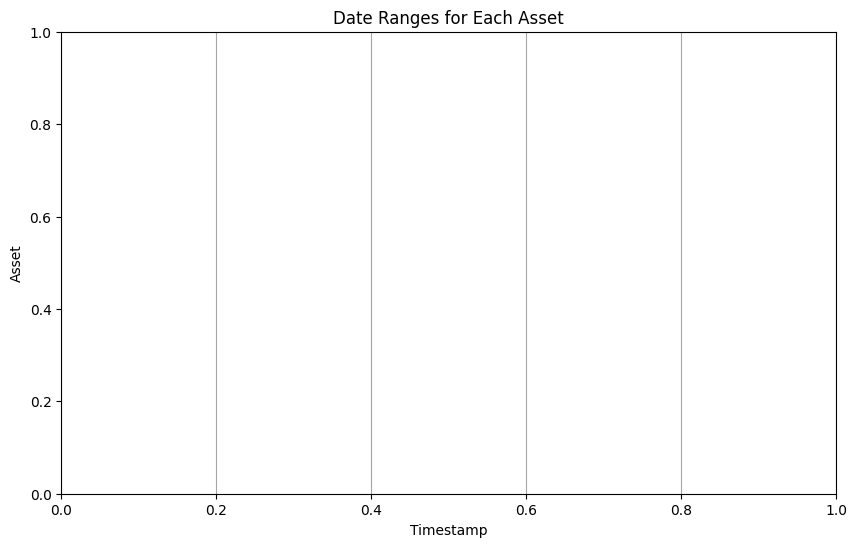

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

# Load all dataframes and extract the time columns
time_columns = []
merged_dfs = []

min_time = np.inf
max_time = 0
for asset in tickers:
    df = pd.read_csv(f"assets/{asset}.csv")
    df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x: int(f"{x}000") if len(str(x)) == 13 else x)
    df = df.sort_values(by=df.columns[0])
    df['Asset'] = asset  # Add a column with the asset name

    min_time = min(min_time, df.iloc[0, 0])
    max_time = max(max_time, df.iloc[-1, 0])

    merged_dfs.append(df)
    time_columns.append(set(df.iloc[:, 0]))


# Create a plot for the date ranges of each asset
plt.figure(figsize=(10, 6))
for asset, df in zip(tickers, merged_dfs):
    asset_times = pd.to_datetime(df.iloc[:, 0], unit='us')
    plt.scatter(asset_times, [asset] * len(asset_times), label=asset, s=1)

plt.xlabel("Timestamp")
plt.ylabel("Asset")
plt.title("Date Ranges for Each Asset")
plt.grid(axis='x', which='major', linestyle='-', color='gray', alpha=0.7)
plt.xticks(pd.date_range(start=pd.to_datetime(min_time, unit='us'), 
                         end=pd.to_datetime(max_time, unit='us'), 
                         freq='Y'), rotation=45)
plt.grid(axis='x', which='minor', linestyle=':', color='gray', alpha=0.5)
plt.minorticks_on()
plt.gca().xaxis.set_minor_locator(plt.matplotlib.dates.MonthLocator())
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig(plotOutput)
# plt.show()
display(plt)


In [ ]:

merged_df = pd.concat(merged_dfs, ignore_index=True)


# Find the minimum common set of times
common_times = reduce(lambda x, y: x & y, time_columns)
common_times = pd.to_datetime(list(common_times), unit='us')
# Group common_times into ranges with no gap greater than 5 minutes
common_times = common_times.sort_values()
ranges = []
start = common_times[0]
prev = common_times[0]

for current in common_times[1:]:
    if (current - prev).total_seconds() > 1800:  # 5 minutes in seconds
        ranges.append((start, prev))
        start = current
    prev = current

ranges.append((start, prev))  # Add the last range

# Convert ranges to a set of tuples
date_ranges = set(ranges)

for start, end in date_ranges:
    duration = end - start
    days = duration.days
    hours = duration.seconds // 3600
    num_half_hour_points = (end - start).total_seconds() // 1800
    
    print(f"{start} to {end}, duration: {days} days and {hours} hours ({int(num_half_hour_points)} windows)")

2019-07-05 12:00:00 to 2019-08-15 01:30:00, duration: 40 days and 13 hours (1947 windows)
2024-03-07 08:00:00 to 2025-02-28 23:30:00, duration: 358 days and 15 hours (17215 windows)
2019-08-15 10:00:00 to 2019-09-30 07:30:00, duration: 45 days and 21 hours (2203 windows)


In [ ]:
output_data = {
    'date_ranges': date_ranges,
    'date_ranges_plot': os.path.abspath(plotOutput),
    'success': target_files
}

print("Saved the data")